In [1]:
import torchvision.models as models
from PIL import Image
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)

/home/mando/glime/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mando/glime/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


263 Pembroke 0.2382734715938568
273 dingo 0.09598098695278168
248 Eskimo dog 0.0682307630777359
264 Cardigan 0.05999341607093811
253 basenji 0.027750516310334206


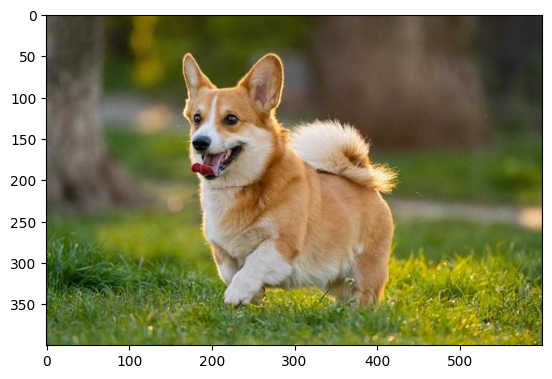

In [2]:
# test the pretrained model using a sample image

input_image = Image.open("data/dog.jpg")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to(device) # create a mini-batch as expected by the model


model.eval()
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Read the categories
with open("data/imgnet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(top5_catid[i].item(), categories[top5_catid[i]], top5_prob[i].item())

# Show the image
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.asarray(input_image))
plt.show()

In [5]:
from lime import BinarySampler, LIMEExplainer, ExponentialKernel
from skimage.segmentation import slic

instance = np.asarray(input_image)
segments = slic(instance, n_segments=25, compactness=10)

kernel = ExponentialKernel(1e5)
sampler = BinarySampler(segments, n_jobs=8, alpha=0.7)
explainer = LIMEExplainer(similarity_kernel=kernel, sampler=sampler, model=model, preprocess=preprocess)

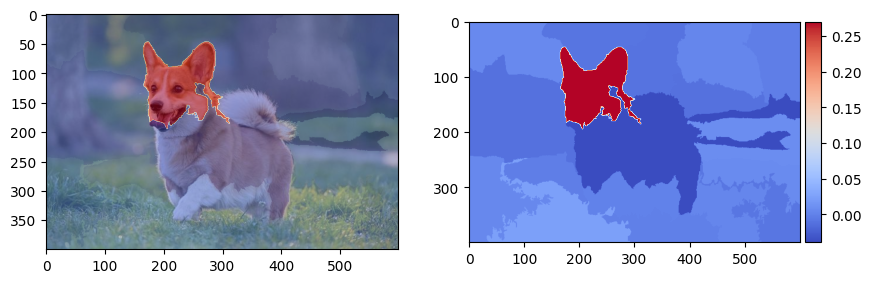

In [4]:
# explain Pembroke
importances = explainer.explain(instance, class_to_explain=263, n_pertubations=700)

In [7]:
from lime import FlowSampler
from glow import GLOW
import pickle

from torchvision.datasets import CelebA

flow = GLOW(3, 32, (3, 96, 96), 40, 256)
flow.model.load('models/glow/glow_celeba_3_32_256_50000.pt')

latent_manipulators = pickle.load(open('latent_manipulators.pkl', 'rb'))

sampler = FlowSampler(flow, latent_manipulators, segments)

transform = transforms.Compose([
        transforms.ToTensor(),
    transforms.Resize(96),
    transforms.CenterCrop(96),
])

train_data = CelebA(root='./data', transform=transform, download=True)

plt.imshow(sampler.sample(1)[0])

/home/mando/glime/.venv/lib/python3.10/site-packages/normflows/core.py:632: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
/home/mando/

TypeError: Sampler.sample() missing 1 required positional argument: 'num_samples'